In [4]:
# Install required packages (if not already installed)
!pip install tensorflow matplotlib scikit-learn

# Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import json


In [6]:
import zipfile
import os

# Specify the zip file path and extraction directory
zip_path = r"C:\Users\jslam\Downloads\rice-leaf.zip"  # Replace with the path to your dataset zip file
extract_to = "dataset"  # Directory to extract the dataset

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Dataset extracted to {extract_to}")



Dataset extracted to dataset


In [10]:
import zipfile
import os

# Specify the zip file path
zip_path = r"C:/Users/jslam/Downloads/rice-leaf.zip"  # Replace with the correct path
extract_to = "dataset"  # Directory where the dataset will be extracted

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Dataset extracted to: {extract_to}")


Dataset extracted to: dataset


In [11]:
import os

# Check the extracted directories
train_dir = os.path.join("dataset", "train")
val_dir = os.path.join("dataset", "validation")

print("Train Directory Exists:", os.path.exists(train_dir))
print("Validation Directory Exists:", os.path.exists(val_dir))


Train Directory Exists: False
Validation Directory Exists: False


In [13]:
train_dir = r"C:\Users\jslam\Downloads\rice-leaf\rice\train"
val_dir = r"C:\Users\jslam\Downloads\rice-leaf\rice\validation"


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 157 images belonging to 3 classes.
Found 84 images belonging to 3 classes.


In [15]:
print(os.listdir("dataset"))
print(os.listdir(train_dir))


['rice']
['bacterial_leaf_blight', 'blast', 'brownspot']


In [16]:
# Get class indices from the generator
class_indices = train_generator.class_indices
print("Class Indices:", class_indices)

# Save class mappings to JSON for reference
import json
with open('classes.json', 'w') as f:
    json.dump({v: k for k, v in class_indices.items()}, f)


Class Indices: {'bacterial_leaf_blight': 0, 'blast': 1, 'brownspot': 2}


In [18]:
# Load label mappings from JSON
with open('classes.json', 'r') as f:
    class_names = json.load(f)

# Ensure class names align with the dataset
print("Class Names:", class_names)


Class Names: {'0': 'bacterial_leaf_blight', '1': 'blast', '2': 'brownspot'}


In [19]:
# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 5, 5, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           3,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,904,035 (91.19 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [20]:
# Train the model
EPOCHS = 25

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


C:\Users\jslam\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5767 - loss: 1.2840 - val_accuracy: 0.4643 - val_loss: 2.9450
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8644 - loss: 0.6012 - val_accuracy: 0.3452 - val_loss: 2.8118
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8409 - loss: 0.4467 - val_accuracy: 0.5595 - val_loss: 2.4942
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9336 - loss: 0.4048 - val_accuracy: 0.5238 - val_loss: 1.8119
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9321 - loss: 0.2059 - val_accuracy: 0.6667 - val_loss: 2.1417
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 12s/step - accuracy: 0.9516 - loss: 0.0910 - val_accuracy: 0.5952 - val_loss: 2.0041
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 107s 27s/step - accuracy: 0.9743 - loss: 0.0686 - val_accuracy: 0.5714 - val_loss: 1.9996
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9817 - loss: 0.0364 - val_accuracy: 0.6310 - val_loss: 2.1203
Epoch 9/25

In [21]:
# Evaluate model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Confusion matrix and classification report
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
print("Confusion Matrix")
print(confusion_matrix(val_generator.classes, y_pred))
print("\nClassification Report")
print(classification_report(val_generator.classes, y_pred, target_names=class_names.values()))


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 819ms/step - accuracy: 0.6062 - loss: 2.3482
Validation Loss: 2.3038387298583984
Validation Accuracy: 0.5952380895614624
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step 
Confusion Matrix
[[21 11 11]
 [13  8  3]
 [ 9  6  2]]

Classification Report
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.49      0.49      0.49        43
                blast       0.32      0.33      0.33        24
            brownspot       0.12      0.12      0.12        17

             accuracy                           0.37        84
            macro avg       0.31      0.31      0.31        84
         weighted avg       0.37      0.37      0.37        84



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


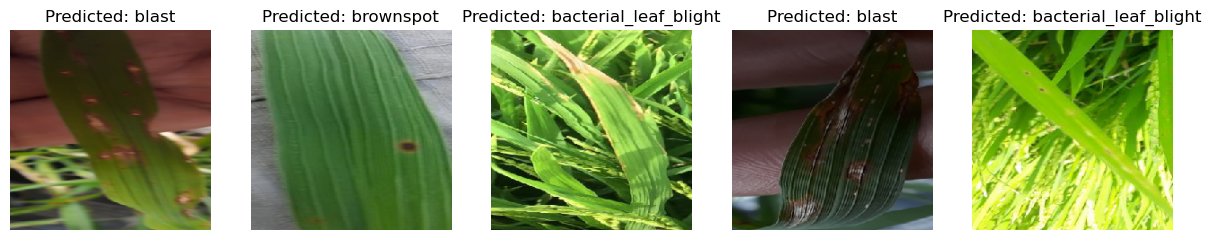

In [22]:
# Randomly select images and visualize predictions
import random

def plot_predictions(generator, num_images=5):
    class_labels = list(class_names.values())
    plt.figure(figsize=(15, 15))

    for i in range(num_images):
        img_index = random.randint(0, len(generator.filenames) - 1)
        img_path = os.path.join(generator.filepaths[img_index])
        img = tf.keras.utils.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = tf.keras.utils.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        predicted_label = class_labels[np.argmax(prediction)]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
    plt.show()

plot_predictions(val_generator)


In [23]:
# Save the trained model
model.save('rice_disease_detector.h5')
print("Model saved as 'rice_disease_detector.h5'")


Model saved as 'rice_disease_detector.h5'


In [26]:
# Load the saved model for testing
new_model = tf.keras.models.load_model('rice_disease_detector.h5')

# Test on a new image
test_img_path = r"C:\Users\jslam\Downloads\rice-leaf\rice\validation\blast\blast_rotated_001.jpg"  # Replace with your image path
test_img = tf.keras.utils.load_img(test_img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
test_img_array = tf.keras.utils.img_to_array(test_img) / 255.0
test_img_array = np.expand_dims(test_img_array, axis=0)

# Predict
test_prediction = new_model.predict(test_img_array)
predicted_class = class_names[str(np.argmax(test_prediction))]
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted class: brownspot


In [28]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3

# Number of classes (update based on your dataset)
num_classes = 3

# Build the model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Adjust output units to match dataset
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Evaluate the model
results = model.evaluate(val_generator)
print("Evaluation Results:", results)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5660 - loss: 1.9176 - val_accuracy: 0.2024 - val_loss: 4.8913
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6556 - loss: 1.4373 - val_accuracy: 0.5714 - val_loss: 2.9870
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7955 - loss: 1.0287 - val_accuracy: 0.5714 - val_loss: 2.1669
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9134 - loss: 0.3190 - val_accuracy: 0.4762 - val_loss: 3.2897
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.8639 - loss: 0.3080 - val_accuracy: 0.5952 - val_loss: 2.2456
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9276 - loss: 0.2391 - val_accuracy: 0.6667 - val_loss: 2.4159
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9211 - loss: 0.2834 - val_accuracy: 0.6071 - val_loss: 1.9386
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9714 - loss: 0.0712 - val_accuracy: 0.6071 - val_loss: 2.0417
Epoch 9/10
5/5 

In [29]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 818ms/step - accuracy: 0.6044 - loss: 1.9169
Validation Loss: 1.9154125452041626
Validation Accuracy: 0.6071428656578064


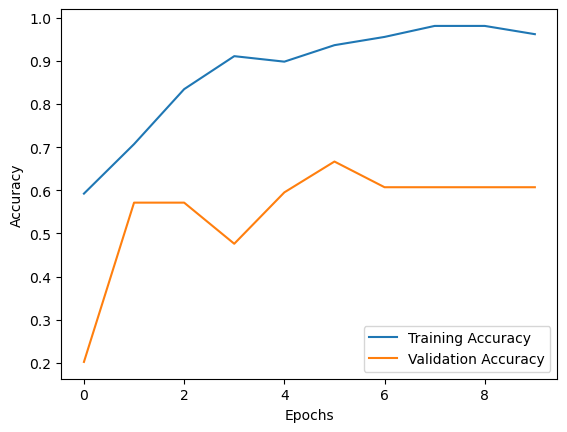

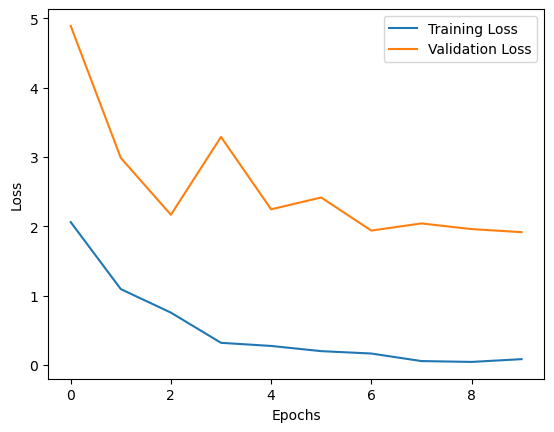

In [31]:
# Plotting training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 845ms/step
Classification Report:
                       precision    recall  f1-score   support

bacterial_leaf_blight       0.52      0.56      0.54        43
                blast       0.26      0.21      0.23        24
            brownspot       0.11      0.12      0.11        17

             accuracy                           0.37        84
            macro avg       0.30      0.29      0.29        84
         weighted avg       0.36      0.37      0.37        84



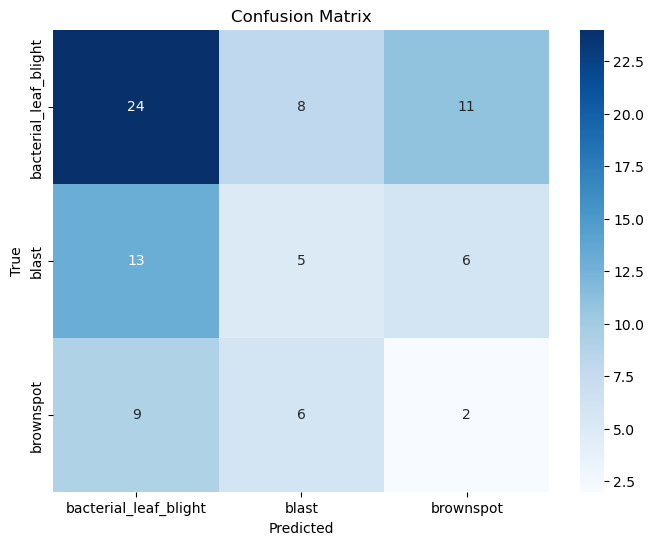

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Get true labels and predictions
Y_true = val_generator.classes
Y_pred = model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=list(val_generator.class_indices.keys())))

# Confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [33]:
# Save the model
model.save("rice_leaf_disease_model.h5")
print("Model saved as 'rice_leaf_disease_model.h5'")


Model saved as 'rice_leaf_disease_model.h5'


In [37]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Function to predict a new image
def predict_new_image(img_path):
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))  # Load the image
    img_array = img_to_array(img) / 255.0  # Normalize and convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (model expects a batch of images)

    # Predict
    prediction = loaded_model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)

    # Return the predicted class name
    class_labels = list(train_generator.class_indices.keys())  # Get class labels from the training generator
    return class_labels[predicted_class[0]]

# Example usage
new_img_path = r"C:\Users\jslam\Downloads\rice-leaf\rice\validation\blast\blast_rotated_001.jpg"  # Replace with your image path
predicted_class = predict_new_image(new_img_path)
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: brownspot


In [38]:
# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 813ms/step - accuracy: 0.6278 - loss: 1.8360
Validation Loss: 1.9154125452041626
Validation Accuracy: 0.6071428656578064
